# Loading packages

In [149]:
import cv2
import numpy as np
import keras.models

In [37]:
!pip install imutils

  Stored in directory: C:\Users\henri\AppData\Local\pip\Cache\wheels\16\84\1f\bf88641293cda2c8be81a5c4b8ca973dd9125a6dc3767417fd
Successfully built imutils


You are using pip version 19.0.3, however version 19.2.3 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [38]:
from imutils.perspective import four_point_transform
from imutils import contours
import imutils

# Preprocessing

In [159]:
# import the necessary packages
from imutils.perspective import four_point_transform
from imutils import contours
import imutils
import cv2

In [160]:
 # define the dictionary of digit segments so we can identify
# each digit on the thermostat
DIGITS_LOOKUP = {
	(1, 1, 1, 0, 1, 1, 1): 0,
	(0, 0, 1, 0, 0, 1, 0): 1,
	(1, 0, 1, 1, 1, 1, 0): 2,
	(1, 0, 1, 1, 0, 1, 1): 3,
	(0, 1, 1, 1, 0, 1, 0): 4,
	(1, 1, 0, 1, 0, 1, 1): 5,
	(1, 1, 0, 1, 1, 1, 1): 6,
	(1, 0, 1, 0, 0, 1, 0): 7,
	(1, 1, 1, 1, 1, 1, 1): 8,
	(1, 1, 1, 1, 0, 1, 1): 9
}

In [189]:
# load the example image
image = cv2.imread("data/HQ_digital/39dbdff5337ff8bf555923bf6b4e7918ddf698af.jpg")

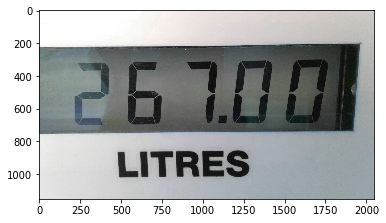

In [190]:
plt.imshow(image)

In [196]:
# pre-process the image by resizing it, converting it to
# graycale, blurring it, and computing an edge map
image = imutils.resize(image, height=500)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edged = cv2.Canny(blurred, 50, 200, 255)

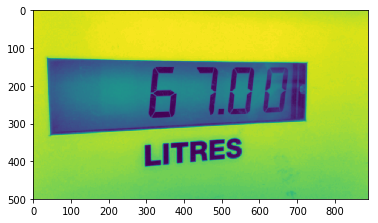

In [197]:
plt.imshow(blurred)

In [198]:
# find contours in the edge map, then sort them by their
# size in descending order
cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL,
	cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
displayCnt = None
 
# loop over the contours
for c in cnts:
	# approximate the contour
	peri = cv2.arcLength(c, True)
	approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
	# if the contour has four vertices, then we have found
	# the thermostat display
	if len(approx) == 4:
		displayCnt = approx
		break

In [199]:
# extract the thermostat display, apply a perspective transform
# to it
warped = four_point_transform(gray, displayCnt.reshape(4, 2))
output = four_point_transform(image, displayCnt.reshape(4, 2))

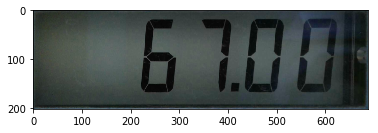

In [201]:
plt.imshow(output)

In [202]:
# threshold the warped image, then apply a series of morphological
# operations to cleanup the thresholded image
thresh = cv2.threshold(warped, 0, 255,
	cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (1, 5))
thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

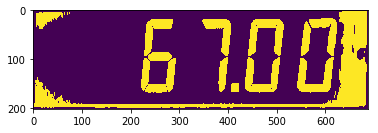

In [203]:
plt.imshow(thresh)